# Trend following rate of change strategy with trailing stop loss

#### The strategy was created by Biarys Saktaganov

## Summary:
### This is a trend following strategy with 17,58% annual return and -23% max. drawdown that buys top 20 stocks based on 170 day rate of change ranking. Also, the rate of change for the past 90 days has to be at least 20%. The initial code is presented below and the final code is presented in the end. The strategy was tested on S&P 500 universe from January 1, 1990 to January 27, 2017. Commission = 10 dollars per trade.

### This research has 3 main parts:
### Part 1: Initial results - where initial code and statistics are presented and main issues are identified
### Part 2: Optimization - finding robust values for the strategy
### Part 3: Conclusion - final thoughts and reflection on the process

##### Terms used:
1) SMA = Simple Moving Average<br>
2) ROC = Rate of Change<br>
3) CAR = Cumulative Annual Return<br>
4) Payoff Ratio = Ratio of average win / average loss<br>
5) Drawdown = Peak-to-trough decline during a specific recorded period of an investment (Investopedia)


### Part 1 - Initial results

//initiate standard options<br>
SetFormulaName("TF ROC with Trailing SL"); <br>
SetOption("InitialEquity", 100000);<br>
SetOption("MinShares", 1 );<br>
SetOption("MarginRequirement", 100);<br>
SetOption("UsePrevBarEquityForPosSizing", True );<br>
SetTradeDelays( 1, 1, 1, 1 ); <br>
SetOption("AllowSameBarExit", false );<br>
PosQty = Optimize("ROC N", 20, 10, 250, 10);<br>
SetOption("MaxOpenPositions", PosQty);<br>
SetOption("AllowPositionShrinking", 1);<br>
paramvalue = ROC (C, Optimize("ROC N", 20, 10, 250, 10));<br>

PositionScore = paramvalue;<br>
PositionSize = -100/PosQty;

//liquidity<br>
vl = MA(Volume,10) > 500000; //volume liquidity. At least 500,000 shares traded based on 10 day moving average <br>
pl = C > 2; //price liquidity. Since stock prices are back adjusted, I use 2$.<br>

//strategy<br>
posROC = ROC(C, 20) > 0;

Buy = vl AND pl AND posROC; <br>
Sell = 0;

//Plot stops<br>
n = Optimize("SL n", 20, 10, 70, 5);<br>
ApplyStop(stopTypeTrailing, stopModePercent, n);

// evaluate stops, all quotes
Equity( 1, 0 ); 

InTrade = Flip( Buy, Sell ); //True when Buy, False when Sell

SetOption("EveryBarNullCheck", True);<br>
stopline = IIf( InTrade, HighestSince( Buy, High ) &ast; ( 1 - 0.01 &ast; 20 ), Null );

//plot chart and trailing stop<br>
Plot(Close,"Price",colorBlack,styleCandle);<br>
SetChartOptions( 0, chartShowDates );<br>
Plot(stopline, "Trailing stop line", colorRed, styleLine, 0, 0, 0, 0);<br>

//plot buy and sell signals

PlotShapes(Buy&ast;shapeUpTriangle,colorWhite,0,Low);<br>
PlotShapes(Sell&ast;shapeDownTriangle,colorAqua,0,High);

//exploration functions<br>
Filter = Buy;<br>
AddColumn(PositionScore, "ROC");

### The initial statistics are:
- Cumulative Annual Return: 11.44%
- Payoff ratio: 3.03
- Max. Drawdown: -59.19%
- CAR/Max. DD: 0.19 <br>
Full statistics are presented in Backtest report #1 on GitHub

In [7]:
from IPython.display import display, HTML
HTML(filename='TF ROC with Trailing SL - Backtest Report 1.html')
#Jupyter notebook does not support multiple tabs, so only 1st tab is shown

From these results we can conclude: <br>
1) CAR is decent<br>
2) Payoff is decent<br>
3) There is a huge drawdown<br>
If we look at the drawdown chart, we can see that the biggest drawdown happened during 2008-2009 financial crisis.

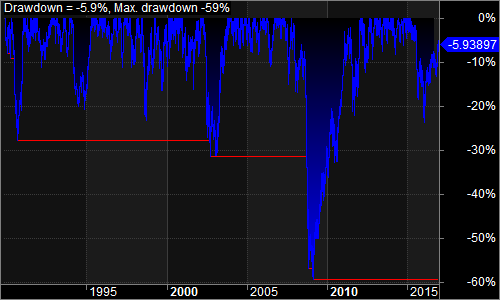

In [2]:
from IPython.display import Image
Image("2. Underwater Equity - bt 1.png")

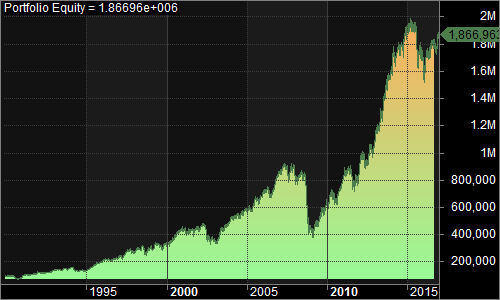

In [8]:
Image("1. Portfolio Equity bt 1.png")

Let's use a market regime filter. We will use a 10 month simple moving average on S&P 500 to identify favourable market condition. Price above 10 month SMA indicates bullish market, while price below 10 month SMA signals bearish market. Since the strategy makes long only trades, when market condition turns bearish it will go flat until the opposite signal is given.

By applying a simple market regime filter, we have drastically reduced maximum drawdown of the strategy from -59% to -23,78%. CAR was also improved by 1,41%. All other parameters stay pretty much the same.

In [9]:
HTML(filename='TF ROC with Trailing SL - Backtest Report 2.html')

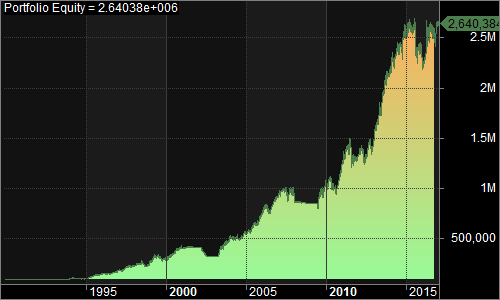

In [10]:
Image("1. Portfolio Equity bt 2.png")

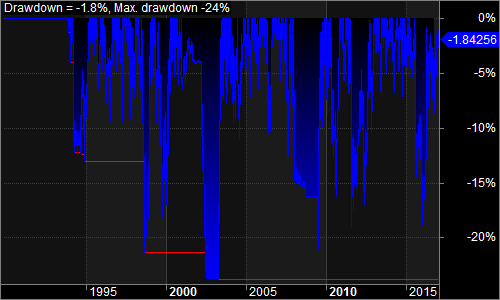

In [11]:
Image("2. Underwater Equity bt 2.png")

Next, let's optimize the strategy. We will start with stop loss percentage and rate of change period. Exhaustive optimization (check every single value) will be performed. Using exhaustive optimization allows us to see the dynamics of the market, not just finding the single best value to use. Stop loss optimization range is 10% - 70% in the increments of 5%. Rate of change is 10 - 250 days in the steps of 10 days.

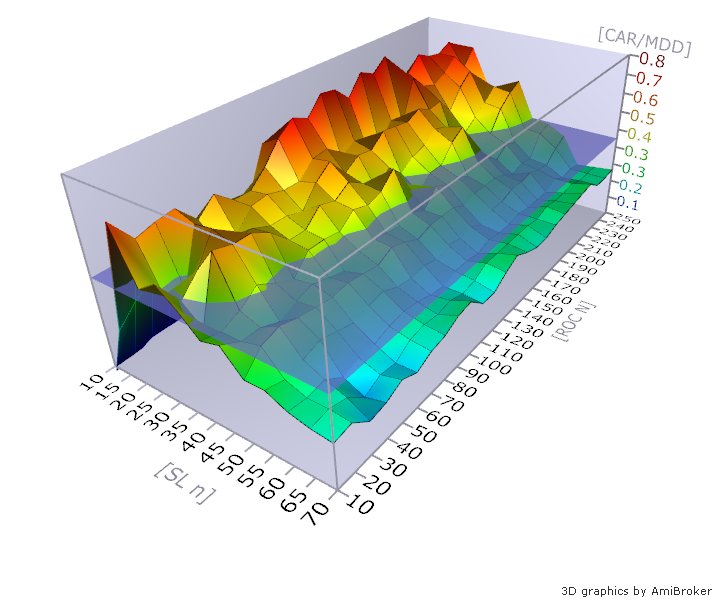

In [12]:
Image("TF ROC with Trailing SL Optimization 1.png")

First of all, having smooth peaks and valleys shows robustness of the strategy. Meaning that small changes in the parameters will not lead to big changes in the result. The best value for stop loss is 20%, and it decreases sharply approaching 0, indicating that the stocks being traded are rather volatile -using stops less than 20% will lead to frequent whipsaws. For that reason, we set stop loss to 20%.

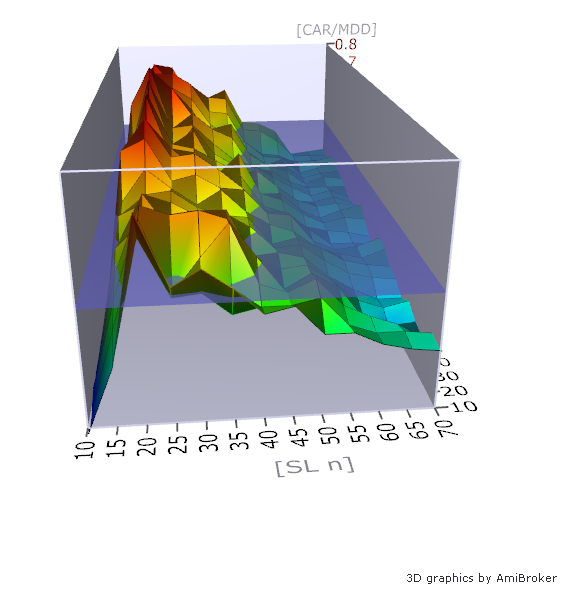

In [13]:
Image("TF ROC with Trailing SL Optimization 1 SL view.png")

At the same time, optimization showed that using a longer term rate of change period, somewhere between 100 and 190 days leads to the best results. Again, having smooth distribution indicated the robustness of the results.

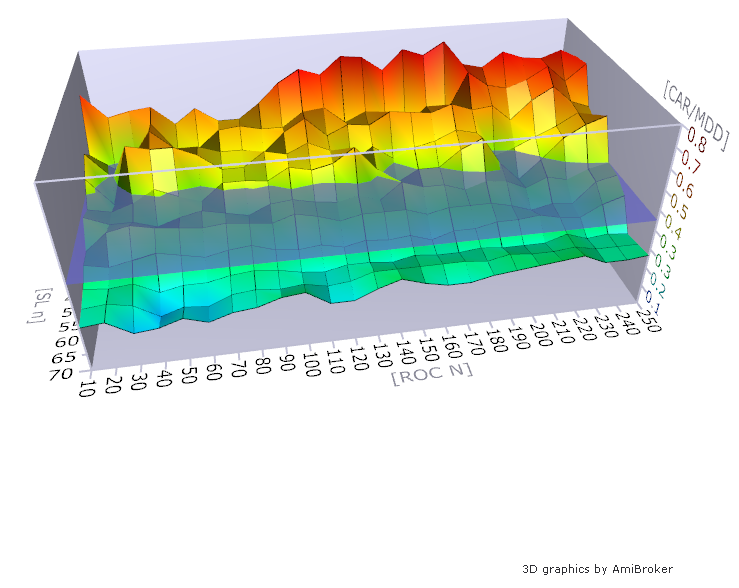

In [14]:
Image("TF ROC with Trailing SL Optimization 1 ROC view.png")

Next, we will optimize ROC period and number of stocks being held to check robustness of ROC period and to see the number of optimal stocks to hold.

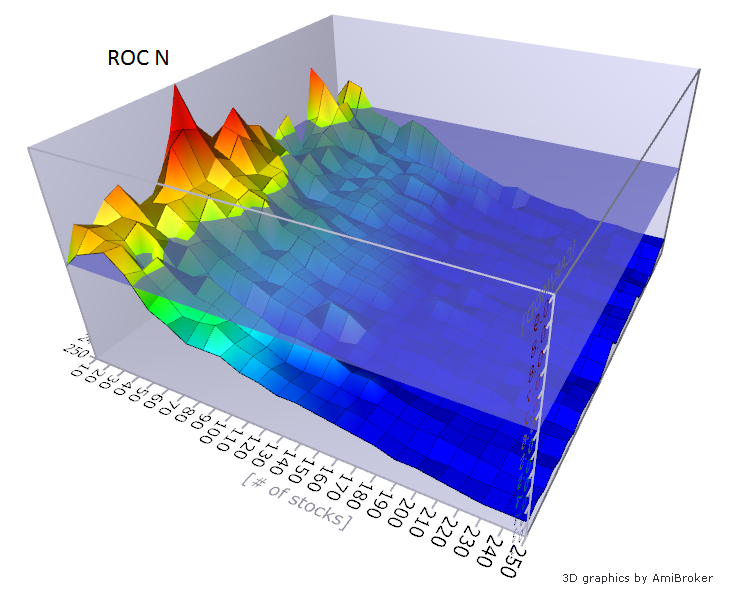

In [4]:
Image("TF ROC with Trailing SL Optimization 2 ROC and Stocks.png")

One thing can be noted right away: sorting stocks based on momentum works best for the smaller number of stocks, and the performance continually decreases the more stocks we add. This makes a lot of sense since momentum identifies the best performing stocks. By adding more stocks of lower ranks, we allocate less capital to the better performing ones and dilute overall performance. The best number of stocks to hold based on the optimization is around 20 stocks.

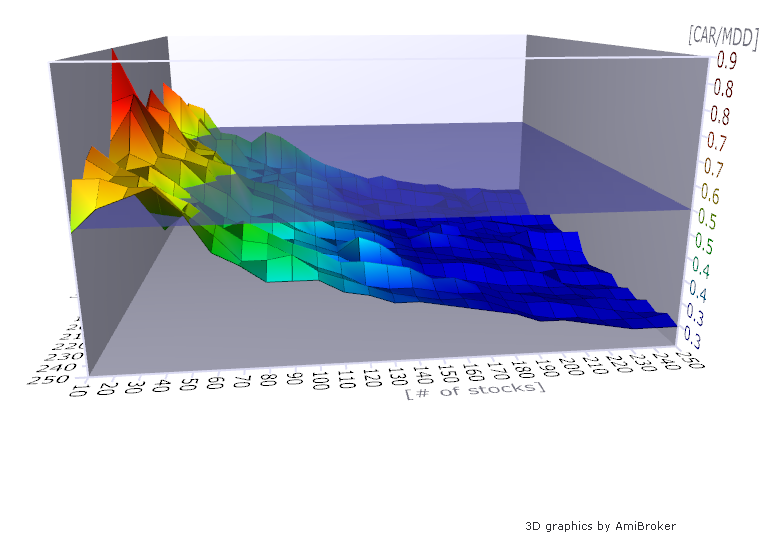

In [5]:
Image("TF ROC with Trailing SL Optimization 2 Stocks view.png")

As for the rate of change, the optimization confirmed our previous opinion. Current run showed the best values are within the previous range of 100 - 190 days. The best value to calculate rate of change is 160 days, which is the value we will use. Note the sharpness of the peak. Normally, we want to avoid using such values because little changes in the period N lead to big changes in the profitability, which indicates the lack of robustness. However in this case, I feel comfortable using 160 days as the adjacent values are profitable and the current result range is similar to the previous optimization run. 

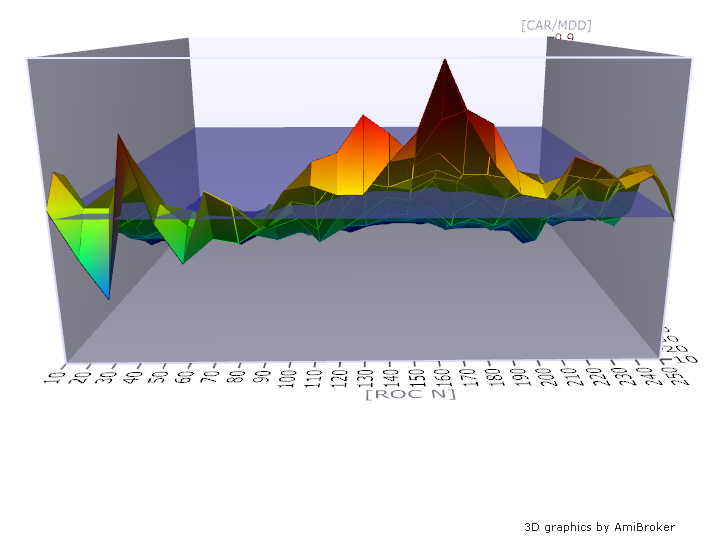

In [6]:
Image("TF ROC with Trailing SL Optimization 2 ROC view.png")

Technically, we could stop here. So far we were able to modify original strategy yielding 11,25% with -59% max. drawdown to a strategy that makes 15,75% annually with -22,7% max. drawdown. The exposure to the market was also reduced to ~68%, down from ~98%. This is largely due to the market regime filter that allows us to exit positions and go flat as the market declines.

In [8]:
HTML(filename='TF ROC with Trailing SL - Backtest Report 3.html')

But let's check if the positive rate of change filter has any impact on the strategy. The purpose of the short term filter is to make sure that only stocks continue to go up in the short term time frame; thus, avoiding stocks that might be in the end of a trend.

As we can see, the filter does have a significant impact on the strategy. By removing the short term filter, the system loses about 4% in annual return and drawdown is increased by ~ -10%

In [9]:
HTML(filename='TF ROC with Trailing SL - Backtest Report 4 - no posROC.html')

Next, we shall look at the optimization matrix between period of short term rate of change (posROC i) and period of rate of change used for ranking (ROC N)

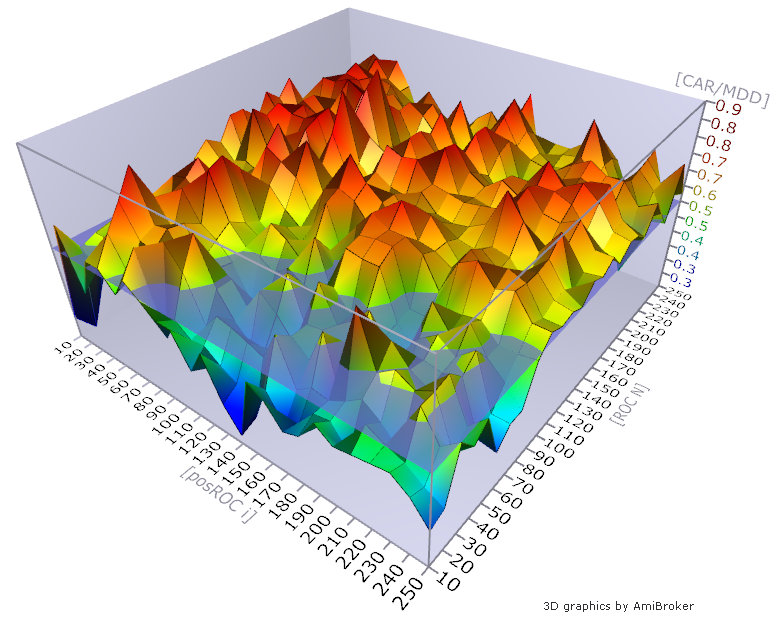

In [12]:
Image("TF ROC with Trailing SL Optimization 3 posROC and ROC N.png")

The results are pretty good. We can see that most results for ROC N starting 100 to 250 are mostly above the water level (above 0.5 CAR/max. drawdown ratio). For posROC i, all results are above the water level for the aforementioned ROC N period, and mostly above water for the periods of 20 - 70. This is better illustrated using a heat map. Having results clustered like that shows a lot of robustness of the parameters. Therefore, we will keep ROC N period at 170.

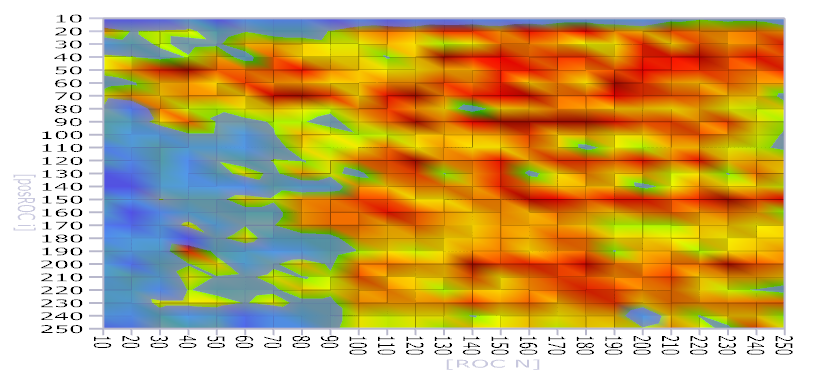

In [11]:
Image("TF ROC with Trailing SL Optimization 3 posROC and ROC N - heat map.png")

Finally, you can recall that short term filter has to be greater than 0% (posROC = ROC(C, i) > 0). Let's examine if 0% is actually a good value to use.

A couple of things can be noticed right away:<br>
1) Using anything over 40% drastically reduces CAR/MDD ratio. This is mostly because there are simply not many stocks that have advanced over 40% in such short period of time. The situation improves slightly as the rate of change period increases, but not much.<br>
2) The best values for Min ROC tend to be under 40%, giving the highest CAR/MDD ratio at 10% - 20%. This indicates that stocks that have advanced up, but haven't gone up too much, are the best candidates for selection.

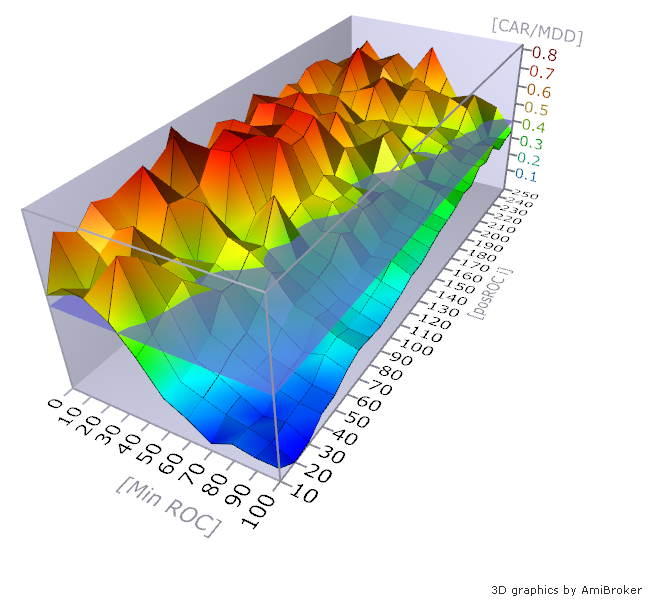

In [13]:
Image("TF ROC with Trailing SL Optimization 3 posROC and min ROC.png")

By looking at the heat map, we can see that the best results are clustered in the middle: between posROC i 50 to 150 days and Min ROC 0% to 40%.

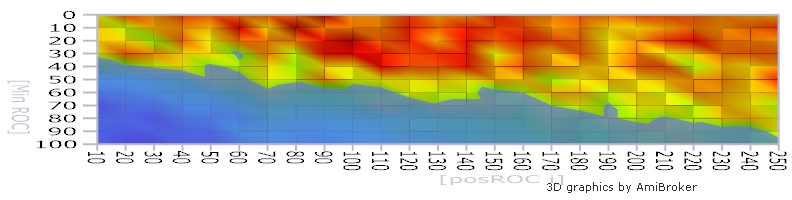

In [14]:
Image("TF ROC with Trailing SL Optimization 3 posROC and min ROC - heat map.png")

Referring back to the ROC N and posROC i heat map, we can see that the best values for posROC i, keeping ROC N at 170 days, are 90, 150, 120, 40, 200, 210... Using 90 days as a short term filter makes sense as it is about half of ROC N period. As for Min ROC, optimization shows that 0% is the best value to use giving CAR/MDD ratio of 0.82. However, we will stay away from it as the solution seems to be over optimized. Using values next to 0% (-10% and +10%) lead to big changes in the outcome. Therefore, we will use 20% as our solution due to smoother optimization curve.

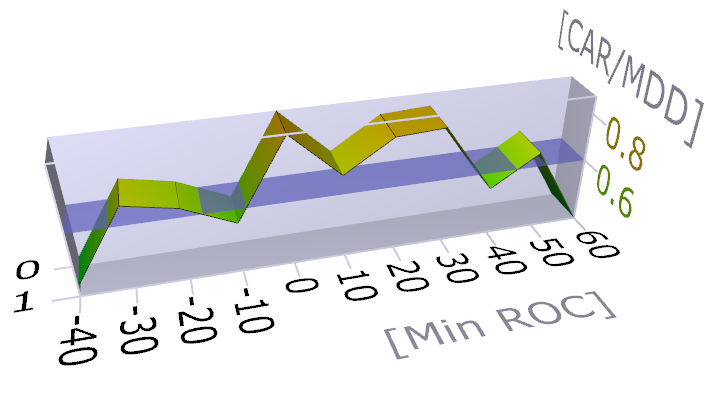

In [15]:
Image("TF ROC with Trailing SL Optimization 3 min ROC only.png")

### Part 3 - Conclusion

We have gone through a long process. Strategy that initially seemed to deliver below average returns was transformed into a pretty solid strategy with CAR of 17,58%, maximum drawdown of 23,28%, and a payoff ratio of 3,05. By adding a market regime filter, the system is able to identify unfavourable market conditions and stay away from them - an important aspect of a long only strategy. 

The most heavy lifting was done during optimization process. Finding optimal results is not an easy task. One of the main challenges is to figure out whether the results are curve fitted, which can result in a time bomb if left unspotted. Of course, these are not the only tests that can be done. To additionally confirm robustness of the strategy, we need to perform walk-forward optimization of the same parameters we have just tested, unless the intention is to have a general optimization values over a long period of time. Furthermore, it is a good idea to stress test the strategy using Monte Carlo simulation. Should the strategy pass all of these tests, then we can paper trade it to see its profitability in the real world. 

Omitting all the technical details, we showed that a simple trend following strategy can yield solid returns while limiting the downside. While S&P 500 is above its 10 month simple moving average, the strategy buys top 20 stocks in the S&P 500 based on momentum, which is measured as the rate of change for the past 170 days. A position is closed when the stock goes down 20% from its entry point; thus, allowing us to cut our losses short. An additional condition is in place to make sure that short term momentum is still present. Specifically, rate of change for the past 90 days has to be greater than 20%.

P.S. All the files can be found in my GitHub repository

#### Final results

In [16]:
HTML("TF ROC with Trailing SL - Backtest Report Final.html")

#### Final сode

//initiate standard options<br>
SetFormulaName("TF ROC with Trailing SL");<br>
SetOption("InitialEquity", 100000);<br>
SetOption("MinShares", 1 );<br>
SetOption("MarginRequirement", 100);<br>
SetOption("UsePrevBarEquityForPosSizing", True );<br>
SetTradeDelays( 1, 1, 1, 1 ); <br>
SetOption("AllowSameBarExit", false );<br>
PosQty = 20; //Optimize("# of stocks", 20, 10, 250, 10);<br>
SetOption("MaxOpenPositions", PosQty);<br>
SetOption("AllowPositionShrinking", 1);<br>
paramvalue = ROC (C, 170); //Optimize("ROC N", 170, 10, 250, 10));<br>

PositionScore = paramvalue;<br>
PositionSize = -100/PosQty;

//liquidity<br>
vl = MA(Volume,10) > 500000; //volume liquidity<br>
pl = C > 2; //price liquidity. Since stock prices are back adjusted, I use 2

//market regime filter<br>
spyClose = Foreign("SPY","C");<br>
spyMonthlyClose = TimeFrameCompress( spyClose, inMonthly );<br>
spyMonthlyMA = MA( spyMonthlyClose, 10 );<br>
spyMonthlyFilter = spyMonthlyClose > spyMonthlyMA;<br>
spyMonthlyFilter = TimeFrameExpand(spyMonthlyFilter, inMonthly); // expand calculated MA to daily, so that we can use it with daily signals

//strategy<br>
i = 90; //Optimize("posROC i", 90, 10, 250, 10);<br>
j = Optimize("Min ROC", 20, -40, 60, 10);<br>
posROC = ROC(C, i) > j;

Buy = vl AND pl AND posROC AND spyMonthlyFilter;<br>
Sell = 0;

//Plot stops<br>
n = 20; //Optimize("SL n", 20, 10, 70, 5);<br>
ApplyStop(stopTypeTrailing, stopModePercent, n);

// evaluate stops, all quotes<br>
Equity( 1, 0 ); 

InTrade = Flip( Buy, Sell ); //True when Buy, False when Sell

SetOption("EveryBarNullCheck", True);<br>
stopline = IIf( InTrade, HighestSince( Buy, High ) &ast; ( 1 - 0.01 * 20 ), Null );

//plot chart and trailing stop<br>
Plot(Close,"Price",colorBlack,styleCandle);<br>
SetChartOptions( 0, chartShowDates );<br>
Plot(stopline, "Trailing stop line", colorRed, styleLine, 0, 0, 0, 0);<br>
//plot buy and sell signals

PlotShapes(Buy&ast;shapeUpTriangle,colorWhite,0,Low);<br>
PlotShapes(Sell&ast;shapeDownTriangle,colorAqua,0,High);

//exploration functions<br>
Filter = Buy;<br>
AddColumn(PositionScore, "ROC");


### The end